# **OCEAN ICE - Density map** #

*Are you curious to see where the most observed oceans are?*


The notebook "OCEAN ICE - Density map" provides an interactive tool to visualize and evaluate the density of measurements for selected parameters. Users can filter the data by parameter (e.g., sea temperature, salinity, or currents), geographic region, time period, and depth making it easy to assess data availability and coverage.
Data are extracted from:

https://ercompwebapps.emodnet-physics.eu/erddap/index.html

Run the code cell below to install and import all the necessary libraries. It also defines two dictionaries to convert user input into the format needed to make requests to ERDDAP.

In [ ]:
# @title
!pip install netcdf4 cartopy xarray # netcdf4==1.6.4 cartopy xarray==0.20.0 numpy==1.26.4

import requests
import os
import netCDF4
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from datetime import datetime
from dateutil.relativedelta import relativedelta
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import calendar
import warnings

warnings.filterwarnings('ignore')

params = {
  'Electrical conductivity': 'CNDC',
 'Dissolved oxygen': 'DOXY',
 'Bathymetric depth': 'BATH',
 'Total alkalinity': 'ALKW',
 'Absolute salinity': 'ASAL',
 'Sea density (sigma-theta)': 'DENS',
 'Total chlorophyll-a': 'CPHL',
 'Air temperature in dry bulb': 'DRYT',
 'Daily precipitation rate (liquid water equivalent)': 'PRRD',
 'Hourly precipitation rate (liquid water equivalent)': 'PRRT',
 'Sound velocity': 'SVEL',
 'Current to direction relative true north': 'HCDT',
 'Nitrate (no3-n)': 'NTRA',
 'Nitrite (no2-n)': 'NTIW',
 'Sea level expressed as pressure': 'PREX',
 'Radial sea water velocity away from instrument': 'RDVA',
 'Silicate (sio4-si)': 'SLCW',
 'Sea temperature from oxygen sensor': 'TEMP_DOXY',
 'Wind strength and direction': 'EWSB',
 'Gust wind speed': 'GSPD',
 'Sound pressure level at 63hz (20s integration time)': 'SPL63',
 'Bottom-top current component': 'VCSP',
 'Wave direction rel. true north': 'VDIR',
 'Average height highest 1/10 wave (h1/10)': 'VH110',
 'Spectral moments (0,2) wave period (tm02)': 'VTM02',
 'Raw current meter output parameters': 'LERR',
 'Longwave/atmospheric incoming radiation': 'LINC',
 'Ph at 25 \\u00b0c and 0 dbar': 'PH25',
 'River flow rate': 'RVFL',
 'Sea temperature from tsg': 'SSJT',
 'Light attenuation coefficient': 'TUR2',
 'Turbidity of water in the water body': 'TUR6',
 'Average height highest 1/3 wave (h1/3)': 'VAVH',
 'Wave spectrum peak energy (smax)': 'VEPK',
 'Beaufort wind force': 'WBFO',
 'Colored dissolved organic matter': 'CDOM',
 'Horizontal velocity of the water column (currents)': 'RFVL',
 'Average period highest 1/3 wave (t1/3)': 'VAVT',
 'Depth of the deepest trough': 'VMNL',
 'Significant wave height': 'VTDH',
 'Air temperature in wet bulb': 'WETT',
 'Chlorophyll-a fluorescence': 'FLU2',
 'Fluorescence': 'FLU3',
 'Dew_point_temperature': 'DEWT',
 'Currents': 'EWCT_NSCT',
 'Co2 partial pressure': 'PCO2',
 'Sound pressure level at 125hz (20s integration time)': 'SPL125',
 'Swell direction rel true n.': 'SWDR',
 'Mean wave from direction': 'THETA1',
 'Wave principal direction at spectral peak': 'VPED',
 'Maximum wave period (tmax)': 'VTMX',
 'Wave period at spectral peak / peak period (tp)': 'VTPK',
 'Surface incoming photosynthetic active radiation': 'LGH4',
 'Net total incoming radiation': 'NRAD',
 'Average period highest 1/10 wave (t1/10)': 'VT110',
 'Hourly rainfall rate': 'HOURLY_RAIN',
 'Dissolved organic nitrogen': 'NODW',
 'Nitrate + nitrite': 'NTRZ',
 'Dissolved oxygen (deprecated)': 'UDOX',
 'Wave directional spreading at spectral peak': 'VPSP',
 'Average zero crossing wave period (tz)': 'VTZA',
 'Maximum zero crossing wave height (hmax)': 'VZMX',
 'Direction of radial vector away from instrument': 'DRVA',
 'Gust wind from direction relative true north': 'GDIR',
 'Horizontal current speed': 'HCSP',
 'Ph': 'PHPH',
 'Total incoming radiation': 'RDIN',
 'Sound pressure level (20s integration time)': 'SPL',
 'Directional spread around theta2': 'STHETA2',
 'Swell height': 'SWHT',
 'Principal wave from direction': 'THETA2',
 'Light transmission': 'TUR3',
 'Generic average wave period': 'VGTA',
 'Light backscattering': 'BACKSCATTERING',
 'Wave direction': 'GWDR',
 'Height_above_mean_sea_level': 'ALTS',
 'Total chlorophyll': 'CHLT',
 'Immerged incoming photosynthetic active radiation': 'LGHT',
 'Phosphate (po4-p)': 'PHOW',
 'Sea potential temperature': 'POTENTIAL_TEMP',
 'Residual sea level (observed - predicted)': 'SLVR',
 'Spectral moments (-1,0) wave period (tm-10)': 'VTM10',
 'Oxygen saturation': 'OSAT',
 'Practical salinity': 'PSAL',
 'Sea sigma-theta': 'SIGMA_THETA',
 'Swell period': 'SWPR',
 'Estimated maximum wave height': 'VEMH',
 'Max period highest 1/3 wave': 'VMAT',
 'Period of the highest wave': 'VTZM',
 'South-north wind component': 'WSPN',
 'Vertical velocity of the water column (currents)': 'LRZA',
 'Shortwave/solar incoming radiation': 'SINC',
 'Water surface height above a specific datum': 'SLEV',
 'Sound pressure level at 2khz (20s integration time)': 'SPL2k',
 'Sea temperature': 'TEMP',
 'Turbidity': 'TURMGL',
 'Mean wave direction from (mdir)': 'VMDR',
 'Height of the highest crest': 'VMXL',
 'Wind from direction relative true north': 'WDIR',
 'Horizontal wind speed': 'WSPD',
 'Atmospheric pressure at altitude': 'ATMP',
 'Atmospheric pressure at sea level': 'ATMS',
 'Dissolved organic carbon': 'CORW',
 'Phycobolin pigment concentrations in the water column': 'PHYC',
 'Relative humidity': 'RELH',
 'Maximum crest trough wave height (hc,max)': 'VCMX',
 'Directional spread around theta1': 'STHETA1',
 'Atmospheric pressure hourly tendency': 'ATPT',
 'Number of bacteria cells in sea water': 'BCCW',
 'Spectral significant wave height (hm0)': 'VHM0',
 'Average zero crossing wave height (hzm)': 'VHZA',
 'Spect. moment(0,2) wave period': 'VSMC',
 'Wave scalar spectral density': 'VSPEC1D',
 'Maximum wave steepness': 'VST1',
 'Wave height and period statistics': 'WVST',
 'Co2 fugacity': 'FCO2',
 'Dissolved nitrogen': 'NGDW',
 'Light scattering': 'SCATTERING',
 'Dissolved inorganic carbon': 'TICW',
 'Total suspended matter': 'TSMP',
 'Generic significant wave height (hs)': 'VGHS',
 'West-east wind component': 'WSPE',
 'Wind to direction relative true north': 'WTODIR',
 'Observed instantaneous water level': 'WLEV'
        }

proj_map = {
    "South Polar": ccrs.SouthPolarStereo(),
}

proj_map_ani = {
    "South Polar": ccrs.SouthPolarStereo(),
}

selected_proj = None
selected_proj_ani = None

depth_bins={
       0: [0, 5],
       5: [5, 10],
       10: [10, 20],
       20: [20, 30],
       30: [30, 40],
       40: [40, 50],
       50: [50, 100],
       100: [100, 250],
       250:[250, 500],
       500: [500, 1000],
       1000: [1000, 1500],
       1500: [1500, 2000],
       2000: [2000, 2500],
       2500: [2500, 10000]
        }

Run the code cells below to create the sliders and drop down menus, then select the filters you want to apply when collecting the data.

Please use the format 'YYYY-MM' for the time range.

In [ ]:
# @title

params_density_resp = requests.get('https://erddap.s4oceandata.eu/erddap/griddap/index.json')

params_density_json = params_density_resp.json()
params_density = params_density_json['table']['rows']
params_density = [dataset[-1] for dataset in params_density_json['table']['rows'] if 'DENSITY_' in dataset[-1] and 'test' not in dataset[-1] and 'v2' not in dataset[-1]]

cleaned_params = {k: v for k, v in params.items() if v in [p.replace('DENSITY_', '') for p in params_density]}

colorbars = {
    "Green to red" : [(0, '#ffffff'), (0.0000000001, '#238823'), (0.5, '#FFBF00'), (1, '#D2222D')],
    "Color blind safe": [(0, '#ffffff'), (0.0000001, '#377eb8'), (0.5, '#ff7f00'), (1,'#4daf4a')],
                  # (0.3, '#f781bf'), (0.4, '#a65628'), (0.5,'#984ea3'),
                  # (0.6, '#999999'), (0.7, '#e41a1c'), (1,'#dede00')],
    "Dark": [(0, '#120128'), (0.0000000001, '#36084D'), (0.34, '#357DED'), (0.67, '#56EEF4'), (1, '#9FF7BF')],

}

selected_var = 'TEMP'
pr_ts = None

def update_selected_param(change):
    global selected_var
    selected_var = change.new
    selected_var = cleaned_params[selected_var]

def update_selected_pr_ts(change):
    global pr_ts
    pr_ts = change.new

dropdown_param = widgets.Dropdown(
    options=cleaned_params.keys(),
    description='Parameter:',
    value= list(cleaned_params.keys())[-1]
)
dropdown_param.observe(update_selected_param, names='value')

pr_ts_dropdown = widgets.Dropdown(
    options=['Time series', 'Profile', 'Both'],
    description='Type:',
)
pr_ts_dropdown.observe(update_selected_pr_ts, names='value')

min_latitude_slider = widgets.FloatSlider(value=-90, min=-90, max=90, step=0.5, description='Min latitude:', style={'description_width': 'initial'})
max_latitude_slider = widgets.FloatSlider(value=90, min=-90, max=90, step=0.5, description='Max latitude:', style={'description_width': 'initial'})
min_longitude_slider = widgets.FloatSlider(value=-180, min=-180, max=180, step=0.5, description='Min longitude:', style={'description_width': 'initial'})
max_longitude_slider = widgets.FloatSlider(value=180, min=-180, max=180, step=0.5, description='Max longitude:', style={'description_width': 'initial'})

start_time_input = widgets.Text(
    placeholder='2024-05',
    description='Start month:',
    disabled=False
)

end_time_input = widgets.Text(
    placeholder='2024-06',
    description='End month:',
    disabled=False
)

colors_dropdown = widgets.Dropdown(
    options=colorbars.keys(),
    description='Color bar:',
    value="Green to red"
)

hbox_1 = HBox([dropdown_param])
hbox_2 = HBox([min_latitude_slider, max_latitude_slider])
hbox_3 = HBox([min_longitude_slider, max_longitude_slider])
hbox_4 = HBox([start_time_input, end_time_input])
hbox_5 = HBox([colors_dropdown])

vbox = VBox([hbox_1,hbox_2, hbox_3, hbox_4, hbox_5])
vbox

In [3]:
# @title
if selected_var is None:
  selected_var = list(cleaned_params.values())[0]

available_depths_resp = requests.get(f'https://erddap.s4oceandata.eu/erddap/griddap/DENSITY_{selected_var}.json?depth')

available_depths_json = available_depths_resp.json()
available_depths_mins = [d[0] for d in available_depths_json['table']['rows']]
available_depths_maxs = [d[1] for d in depth_bins.values() if d[0] in available_depths_mins]

min_depth_slider = widgets.SelectionSlider(
    options=available_depths_mins,
    value=available_depths_mins[0],
    description='Min depth:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
max_depth_slider = widgets.SelectionSlider(
    options=available_depths_maxs,
    value=available_depths_maxs[0],
    description='Max depth:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

VBox([min_depth_slider, max_depth_slider])

In [4]:
# @title
def update_selected_proj(change):
    global selected_proj
    selected_proj = change.new
    selected_proj = proj_map[selected_proj]

dropdown_proj = widgets.Dropdown(
    options=proj_map.keys(),
    description='Projection:',
    value= list(proj_map.keys())[0]
)
dropdown_proj.observe(update_selected_proj, names='value')
display(dropdown_proj)

Dropdown(description='Projection:', options=('South Polar',), value='South Polar')

After selecting the desired parameter and filters, run the code cell below to retrive the data and generate the density map.

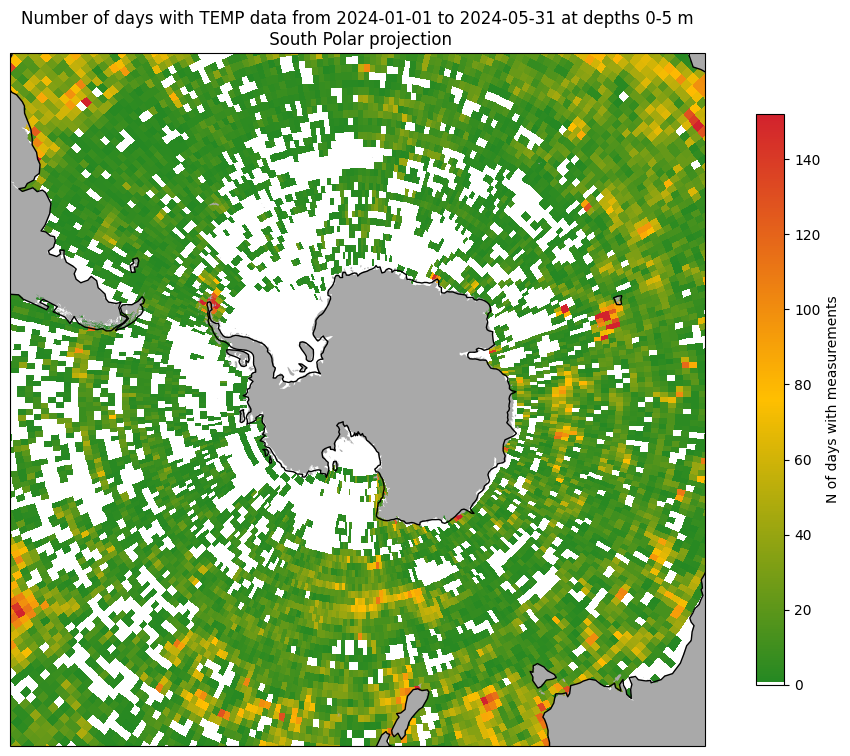

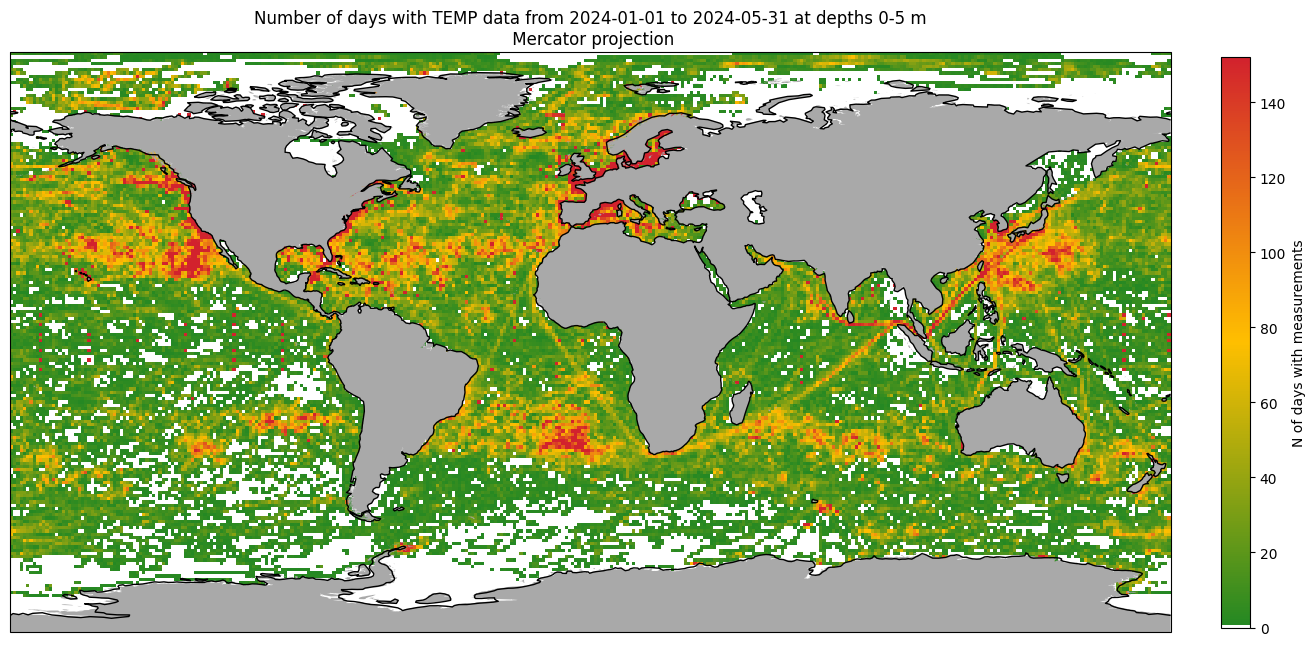

In [ ]:
# @title
if selected_proj is None:
    selected_proj = list(proj_map.values())[0]

if selected_var is None:
    selected_var = list(cleaned_params.values())[0]

min_depth = min_depth_slider.value
max_depth = max_depth_slider.value

selected_depths = [d for d in available_depths_mins if d >= min_depth and d < max_depth]

min_lat = min_latitude_slider.value
max_lat = max_latitude_slider.value
min_lon = min_longitude_slider.value
max_lon = max_longitude_slider.value

min_time = start_time_input.value
max_time = end_time_input.value

if min_time is None or min_time == "":
    min_time = "2024-05"

if max_time is None or max_time == "":
    max_time = "2024-06"

max_time = datetime.strptime(max_time, "%Y-%m")
max_time_str = str(max_time - relativedelta(seconds=1))[:10]
max_time = max_time.strftime("%Y-%m-%d")

color_bar = colors_dropdown.value


def generate_monthly_time_tuples(dt_min, dt_max):
    if relativedelta(dt_max, dt_min).months < 1 and dt_min.year == dt_max.year:
        return [(dt_min, dt_max)]
    times = []
    next_month_start = (dt_min + relativedelta(months=1)).replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    first_end = min(next_month_start, dt_max)
    times.append((dt_min, first_end))
    current_start = next_month_start
    while current_start < dt_max:
        next_month_start = (current_start + relativedelta(months=1)).replace(day=1, hour=0, minute=0, second=0, microsecond=0)
        current_end = min(next_month_start, dt_max)
        times.append((current_start, current_end))
        current_start = next_month_start
    return times


min_time_dt = datetime.strptime(min_time, "%Y-%m")
max_time_dt = datetime.strptime(max_time, "%Y-%m-%d")

if (max_time_dt - min_time_dt).days != 0:
    tot_days = (max_time_dt - min_time_dt).days
else:
    tot_days = ((max_time_dt + relativedelta(months=1)) - min_time_dt).days

time_tuples = generate_monthly_time_tuples(min_time_dt, max_time_dt)
time_tuples = [(t[0].strftime("%Y-%m"), t[1].strftime("%Y-%m")) for t in time_tuples]

grid_dimension = 1
lon_bins = np.arange(-180, 181, grid_dimension)
lat_bins = np.arange(-90, 91, grid_dimension)

accum_heatmap = np.zeros((len(lon_bins) - 1, len(lat_bins) - 1))
monthly_heatmaps = {}
for time_tup in time_tuples:
    min_t, max_t = time_tup

    url = f"https://erddap.s4oceandata.eu/erddap/griddap/DENSITY_{selected_var}.nc?DENSITY%5B({selected_depths[0]}):1:({selected_depths[-1]})%5D%5B({min_t}-01):1:({max_t}-01)%5D%5B({min_lat}):1:({max_lat})%5D%5B({min_lon}):1:({max_lon})%5D"
    resp_netcdf = requests.get(url)

    if resp_netcdf.status_code == 404:
        print(f"No data found from {min_t} to {max_t}")
        continue

    try:
        ds = xr.open_dataset(resp_netcdf.content, decode_times=False)
        df = ds.to_dataframe().reset_index()
        df["time"] = pd.to_datetime(df["time"], unit="s")

        if "depth" in df.columns and len(df["depth"].unique()) == 1:
            df = df.drop(columns="depth")

        heatmap, _, _ = np.histogram2d(
            df["longitude"],
            df["latitude"],
            bins=[lon_bins, lat_bins],
            weights=df["DENSITY"],
        )
        monthly_heatmaps[min_t] = heatmap
        accum_heatmap += heatmap

        del df, ds

    except Exception as e:
        print(f"Error processing data from {min_t} to {max_t}: {e}")
        print(resp_netcdf)
        print(str(resp_netcdf.content)[:200])

def create_map(heatmap, lon_edges, lat_edges, proj, proj_name, figsize=(16, 9)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    colors = colorbars[color_bar]
    custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

    pcm = ax.pcolormesh(
        lon_edges,
        lat_edges,
        heatmap.T,
        cmap=custom_cmap,
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=tot_days,
    )

    shpfilename = shpreader.natural_earth(resolution="10m", category="physical", name="land")
    reader = shpreader.Reader(shpfilename)
    land_geoms = list(reader.geometries())
    ax.add_geometries(land_geoms, ccrs.PlateCarree(), facecolor="darkgrey")
    ax.coastlines()

    if proj_name == "South Polar":
        ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())
    elif proj_name == "North Polar":
        ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", fraction=0.023, pad=0.041)
    cbar.set_label("N of days with measurements")

    depth_range = f"{min_depth}-{max_depth}"
    ax.set_title(
        f"Number of days with {selected_var} data from {min_time}-01 "
        f"to {max_time_str} at depths {depth_range} m\n {proj_name} projection"
    )

    return fig


if accum_heatmap.sum() > 0:
    proj_name = {v: k for k, v in proj_map.items()}.get(selected_proj)

    fig1 = create_map(accum_heatmap, lon_bins, lat_bins, selected_proj, proj_name)
    display(fig1)
    plt.close(fig1)

    fig2 = create_map(accum_heatmap, lon_bins, lat_bins, ccrs.PlateCarree(), "Mercator")
    display(fig2)
    plt.close(fig2)
else:
    print("No available data for the selected time range")

## Generate animation

Execute the next code cells to generate an animation showing the monthly density maps of the selected variable within the chosen time range, depth range, and spatial extent. Please select from the Dropdown the desired projection for the animation.

In [6]:
# @title
if selected_proj_ani is None:
    selected_proj_ani = list(proj_map_ani.values())[0]
proj_name_ani = {v: k for k, v in proj_map_ani.items()}.get(selected_proj_ani)

unique_months = sorted(monthly_heatmaps.keys())

if proj_name_ani in ["South Polar", "North Polar"]:
    fig = plt.figure(figsize=(9, 9))
else:
    fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1, projection=selected_proj_ani)

shpfilename = shpreader.natural_earth(resolution='10m', category='physical', name='land')
reader = shpreader.Reader(shpfilename)
land_geoms = list(reader.geometries())
ax.add_geometries(land_geoms, ccrs.PlateCarree(), facecolor='darkgrey')
ax.coastlines()

if proj_name_ani == "South Polar":
    ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())
elif proj_name_ani == "North Polar":
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
else:
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

colors = colorbars[color_bar]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

lon_bins = np.arange(-180, 181, 1)
lat_bins = np.arange(-90, 91, 1)
lon_edges, lat_edges = lon_bins, lat_bins

initial_month = unique_months[0]
heatmap = monthly_heatmaps[initial_month]

pcm = ax.pcolormesh(
    lon_edges, lat_edges, heatmap.T,
    cmap=custom_cmap,
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=calendar.monthrange(int(initial_month[:4]), int(initial_month[5:]))[1]
)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.023, pad=0.041)
cbar.set_label('N of days with measurements')

title = ax.set_title(f"{selected_var} density for {initial_month}\n{proj_name_ani} projection")

def update_plot(month):
    heatmap = monthly_heatmaps[month]
    pcm.set_array(heatmap.T.ravel())
    pcm.set_clim(0, calendar.monthrange(int(month[:4]), int(month[5:]))[1])
    title.set_text(f"{selected_var} density for {month}")
    return [pcm, title]

ani = FuncAnimation(fig, update_plot, frames=unique_months, blit=False, interval=500)

plt.close(fig)
HTML(ani.to_html5_video())

This work has received funding from the European Union Horizon Europe project Ocean-Cryosphere Exchanges in ANtarctica: Impacts on Climate and the Earth System (OCEAN ICE) under grant agreement No. 101060452 (https://doi.org/10.3030/101060452). UK partners are funded by UK Research and Innovation (UKRI) under the UK government’s Horizon Europe funding guarantee.
This notebook makes use of data available in the European Marine Observation and Data Network (EMODnet, https://emodnet.ec.europa.eu).

<center>
  <div style="display: flex; justify-content: center; align-items: flex-start; gap: 20px;">
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/TO-USE-RGB-for-digital-materials-V.png" height="100" style="margin-top: 50px;"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/UKRI-logo-1.png" height="80"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2023/06/logo-polar-cluster-2.png" height="80"/>
    <img src="https://emodnet.ec.europa.eu/sites/emodnet.ec.europa.eu/files/public/emodnet_logos/web/EMODnet_standard_colour.png" height="80"/>
  </div>
</center>
